# Классификация изображений

Требуется обучить классификатор изображений. В датасете 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы от 0 до 199. Скачать датасет можно [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.

__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок.

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install pytorch_lightning torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 32.3 MB/s eta 0:00:00


In [ ]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2025-01-09 17:52:17--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/ed781r6u2d8de61xxhcq6/dataset.zip?rlkey=vkvp4kdp03m42ceprg95cg0ax&dl=1 [following]
--2025-01-09 17:52:17--  https://www.dropbox.com/scl/fi/ed781r6u2d8de61xxhcq6/dataset.zip?rlkey=vkvp4kdp03m42ceprg95cg0ax&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc100df5defc2ac81c0c6527d410.dl.dropboxusercontent.com/cd/0/inline/Ch6p6gCRmRAEG7dcczSvOgti2q5ivPJHZ3Jj5MIk88YyBkOFlOQaQXif0NgtsqhLhj0w4iNic2Y3UWL1plataHMcPY5k481jImRGu1YzcoNi2KCKOy0ogQrCE0uk4j-175s/file?dl=1# [following]
--2025-01-09 17:52:17--  https://uc100df5defc2ac81c0c6527d410.dl.dropboxusercontent.com/cd/0/inline/Ch6p6

### Подготовка данных

In [ ]:
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, RandomRotation, RandomVerticalFlip, RandomInvert, GaussianBlur

In [ ]:
train_dataset = ImageFolder('/content/dataset/dataset/train', transform=ToTensor())
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=ToTensor())

In [ ]:
# Инициализация переменных для подсчета
mean = 0.0
std = 0.0
total_images = len(train_dataset)

# Подсчет mean и std
for img, _ in tqdm(train_dataset):
    mean += img.mean([1, 2])  # Среднее по высоте и ширине
    std += img.std([1, 2])    # Стандартное отклонение по высоте и ширине

mean /= total_images
std /= total_images

mean = [round(m.item(), 3) for m in mean]
std = [round(s.item(), 3) for s in std]

print(f'Mean: {mean}')
print(f'Std: {std}')

100%|██████████| 100000/100000 [01:02<00:00, 1596.53it/s]

Mean: [0.48, 0.448, 0.398]
Std: [0.23, 0.226, 0.226]


In [ ]:
train_transform = Compose([ToTensor(),
                           Normalize(mean, std),
                           RandomHorizontalFlip(0.5),
                           RandomVerticalFlip(0.5),
                           RandomRotation(0.5),
                           RandomInvert(0.5),
                           GaussianBlur((5,5), 0.2),
                  ])
val_transform = Compose([ToTensor(),
                         Normalize(mean, std),
                         ])


train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим распределение классов

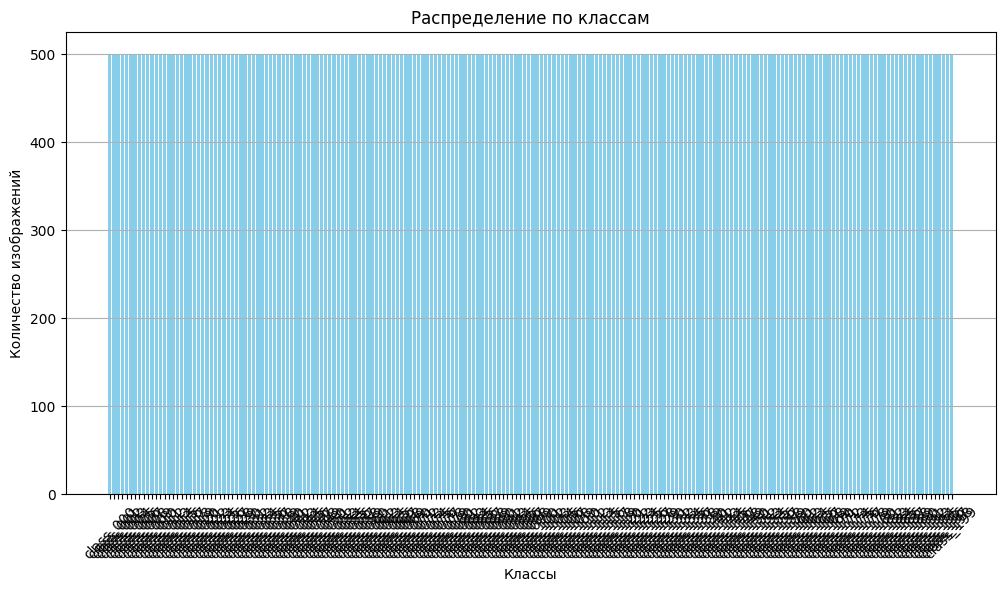

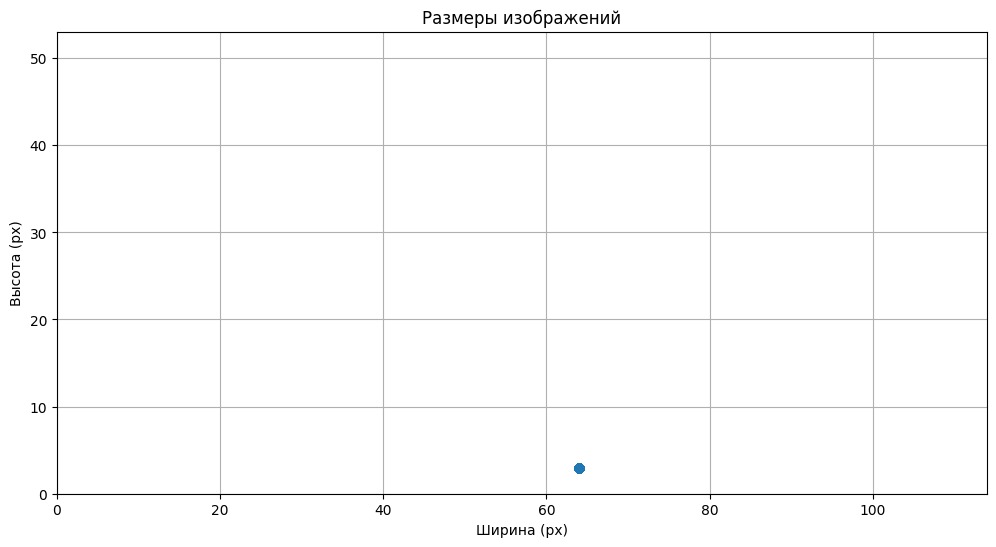

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
# Получение размеров изображений и их классов
image_sizes = [img.size() for img, _ in train_dataset]
class_counts = Counter([label for _, label in train_dataset])

# 1. Визуализация распределения по классам
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(ticks=range(len(train_dataset.classes)), labels=train_dataset.classes, rotation=45)
plt.title('Распределение по классам')
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.grid(axis='y')
plt.show()

# 2. Визуализация размеров изображений
widths = [size[1] for size in image_sizes]  # Ширина
heights = [size[0] for size in image_sizes]  # Высота

plt.figure(figsize=(12, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Размеры изображений')
plt.xlabel('Ширина (px)')
plt.ylabel('Высота (px)')
plt.xlim(0, max(widths) + 50)  # Установите границы для оси X
plt.ylim(0, max(heights) + 50)  # Установите границы для оси Y
plt.grid()
plt.show()


### Посмотрим на картиночки

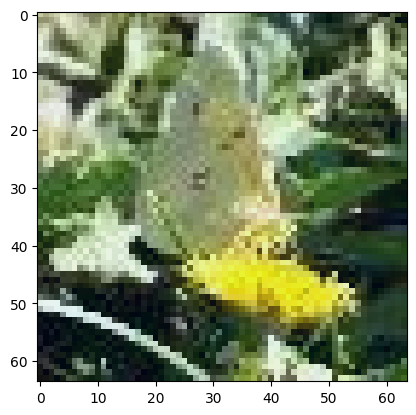

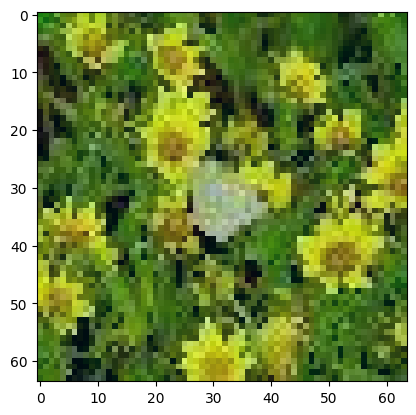

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    images = (images - images.min()) / (images.max() - images.min())
    plt.imshow(images[1].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[20].permute(1, 2, 0))
    plt.show()
    break

## Задание 1. Без использования предобученных весов

Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.

### Напишем класс нашей модели

Будем использовать DenseNet121. Её архитектура представлена на картинке.

In [ ]:
from torchvision.models import densenet121

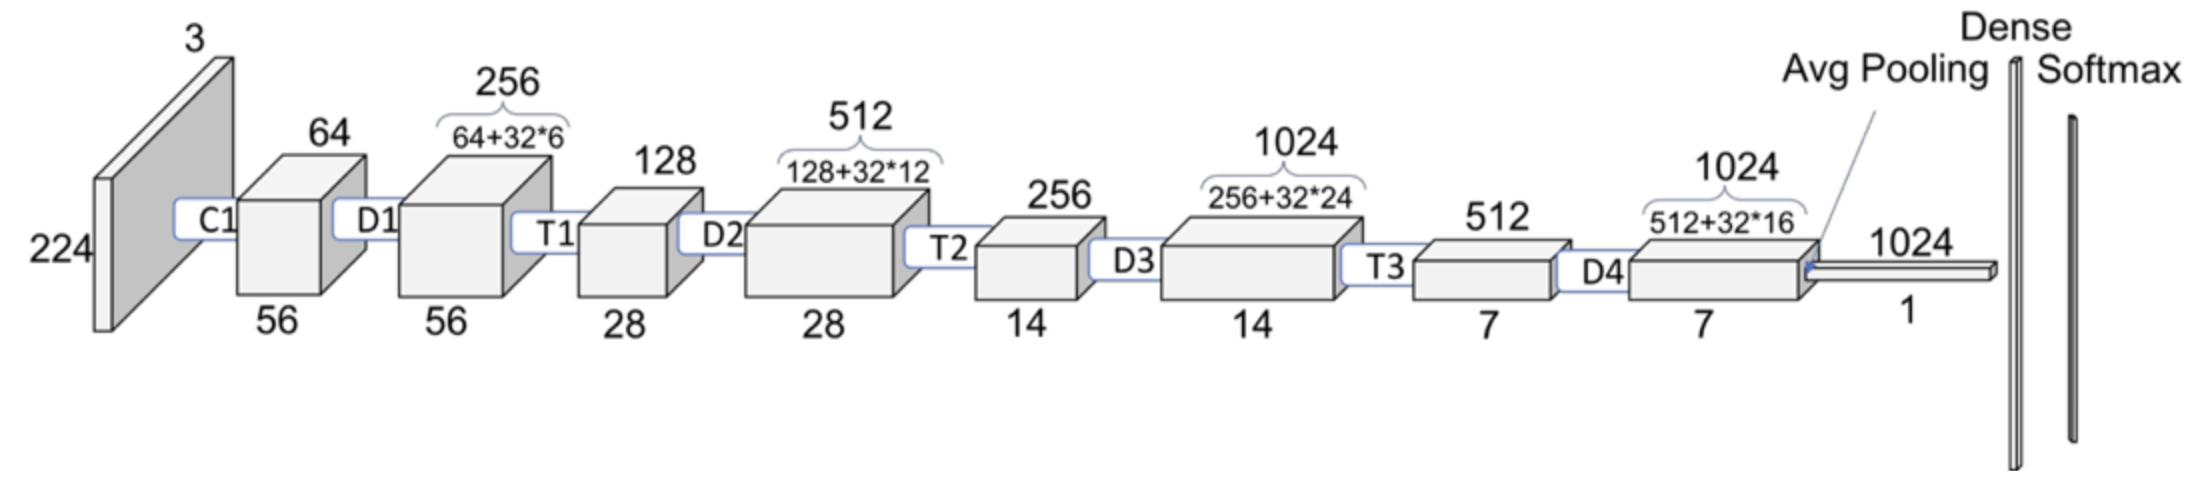

In [ ]:
class YourNet(torch.nn.Module):
    def __init__(self, pretrained=False, freeze_weights=False):
        super().__init__()

        # Используем DenseNet121 для классификации изображений
        if pretrained:
          self.model = densenet121(weights="IMAGENET1K_V1")
        else:
          self.model = densenet121(weights=None)

        if freeze_weights:
          for param in self.model.features.parameters():
            param.requires_grad = False

        self.model.classifier = nn.Linear(in_features=1024, out_features=200, bias=True)  # Настраиваем выход под 200 классов

        self.loss_func = nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()
        self.accuracy = 0

    def _forward(self, x):
        # Проводим прямое распространение через нейронную сеть
        return self.model(x)

    def forward(self, images, target=None):
        output = self._forward(images)

        if target is not None:
            loss = self.loss_func(output, target)
            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long(), task="multiclass", num_classes=200)
            return loss
        return output

    def get_accuracy(self, reset=False):
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Создадим модуль Lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-3, optimizer='Adam', lr_func=None):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.optim = optimizer
        self.lr_func = lr_func
        self.train_losses = []
        self.epoch_train_losses = []
        self.val_losses = []
        self.epoch_val_losses = []
        self.val_accuracies = []
        self.epoch_val_accuracies = []

    def forward(self, x):
        # Прямой проход для предсказаний
        return self.model(x)

    def configure_optimizers(self):
        if self.optim == 'Adam':
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif self.optim == 'LambdaLR':
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=self.lr_func)
            return [optimizer], [scheduler]
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, targets = train_batch
        loss = self.model(images, targets)  # Считаем предсказания и loss
        self.train_losses.append(loss.item())
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, targets = val_batch
        loss = self.model(images, targets)  # Считаем предсказания и loss

        # Логируем точность и лосс
        val_accuracy = self.model.get_accuracy(reset=True)
        self.val_losses.append(loss.item())
        self.val_accuracies.append(val_accuracy.item())

        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_accuracy", val_accuracy, on_epoch=True, prog_bar=True, logger=True)
        return {"val_loss": loss, "val_accuracy": val_accuracy}

### Подключим Callback для вывода информации и графиков

In [ ]:
class PlotCallback(pl.Callback):
    def __init__(self, module):
        self.module = module

    def on_train_epoch_end(self, trainer, pl_module):
        avg_train_loss = np.mean(self.module.train_losses)
        self.module.epoch_train_losses.append(avg_train_loss)
        self.module.train_losses = []
        print(f"Train Loss (epoch {trainer.current_epoch}): {avg_train_loss}")

    def on_validation_epoch_end(self, trainer, pl_module):
        avg_val_loss = np.mean(self.module.val_losses)
        avg_val_accuracy = np.mean(self.module.val_accuracies)
        self.module.epoch_val_losses.append(avg_val_loss)
        self.module.epoch_val_accuracies.append(avg_val_accuracy)
        self.module.val_losses = []
        self.module.val_accuracies = []
        print(f"Validation Loss (epoch {trainer.current_epoch}): {avg_val_loss}")
        print(f"Validation Accuracy (epoch {trainer.current_epoch}): {avg_val_accuracy}")

    def on_fit_end(self, trainer, pl_module):
        # Построение графиков после завершения обучения
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.module.epoch_train_losses) + 1), self.module.epoch_train_losses, label='Train Loss')
        plt.title('Train Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.module.epoch_val_accuracies) + 1), self.module.epoch_val_accuracies, label='Validation Accuracy')
        plt.title('Validation Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.module.epoch_val_losses) + 1), self.module.epoch_val_losses, label='Validation Loss')
        plt.title('Validation Loss Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

### Обучим нашу модель

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | YourNet | 7.2 M  | train
------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)
435       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 0): 5.707318067550659
Validation Accuracy (epoch 0): 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 0): 4.058115423105325
Validation Accuracy (epoch 0): 0.12496718659902074
Train Loss (epoch 0): 4.50481619609142


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 1): 3.5176885932873767
Validation Accuracy (epoch 1): 0.2001653336415625
Train Loss (epoch 1): 3.698349259712722


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 2): 3.181878807438407
Validation Accuracy (epoch 2): 0.26247520061435214
Train Loss (epoch 2): 3.325007101548305


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 3): 3.028264036603794
Validation Accuracy (epoch 3): 0.2918574787249231
Train Loss (epoch 3): 3.0408063676215407


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 4): 2.837225112186116
Validation Accuracy (epoch 4): 0.32966356938052327
Train Loss (epoch 4): 2.810922473802524


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 5): 2.718520175119874
Validation Accuracy (epoch 5): 0.36125949461748647
Train Loss (epoch 5): 2.6004956054595976


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 6): 2.654393430728062
Validation Accuracy (epoch 6): 0.37303552487093933
Train Loss (epoch 6): 2.414176213154027


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 7): 2.594631120657465
Validation Accuracy (epoch 7): 0.38829311652547993
Train Loss (epoch 7): 2.2416897643779383


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 8): 2.569620321510704
Validation Accuracy (epoch 8): 0.3982625960544416
Train Loss (epoch 8): 2.0716354848479734


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 9): 2.5353779132199135
Validation Accuracy (epoch 9): 0.40407047150241343
Train Loss (epoch 9): 1.907320422464201


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 10): 2.5369964002803633
Validation Accuracy (epoch 10): 0.4084488157254116
Train Loss (epoch 10): 1.763944882043874


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 11): 2.521320090172397
Validation Accuracy (epoch 11): 0.4206950227925732
Train Loss (epoch 11): 1.61729403977507


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 12): 2.556293534625108
Validation Accuracy (epoch 12): 0.41702084556506697
Train Loss (epoch 12): 1.4754473341251138


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 13): 2.579738042916462
Validation Accuracy (epoch 13): 0.421297184980599
Train Loss (epoch 13): 1.3463961432472835


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 14): 2.6220182727096946
Validation Accuracy (epoch 14): 0.4216829891417437
Train Loss (epoch 14): 1.2260764364393872


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


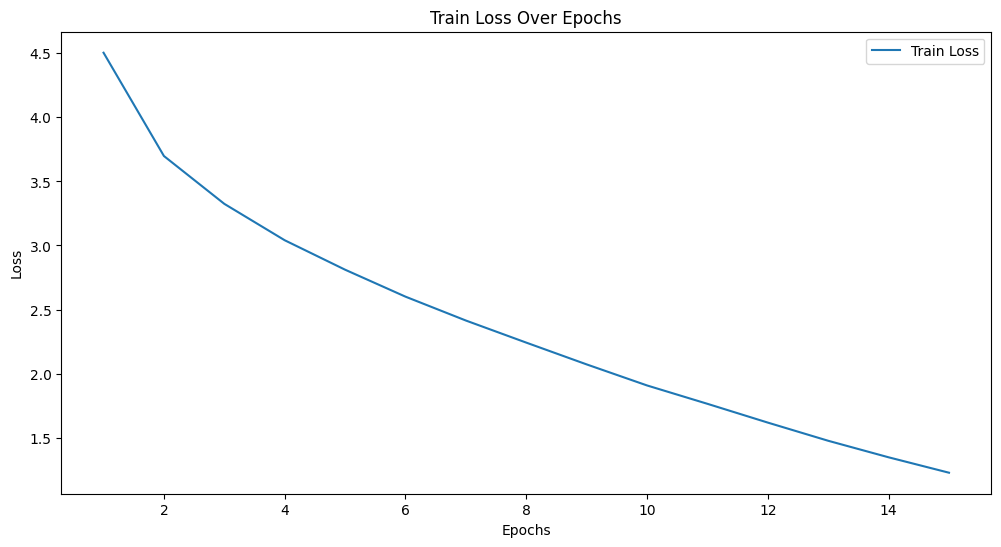

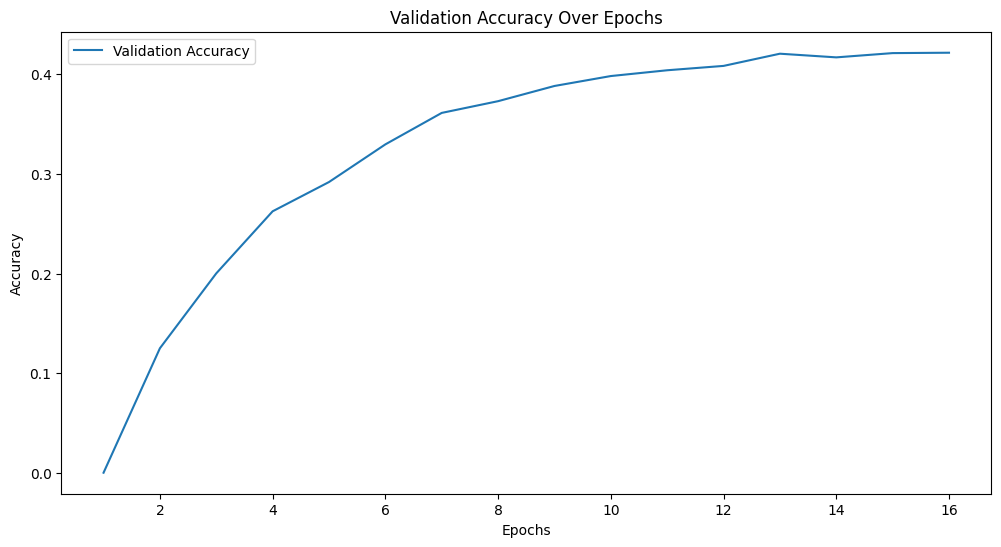

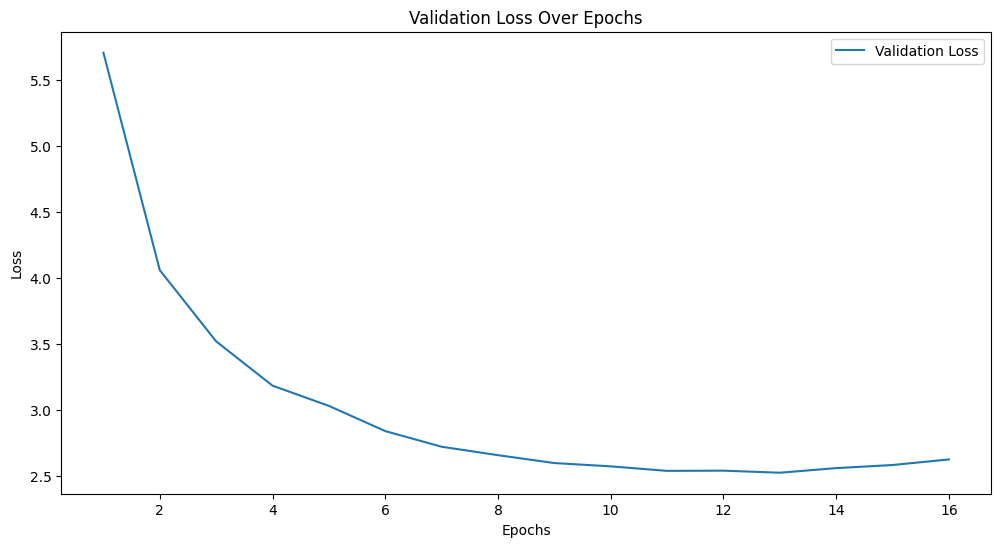

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YourNet().to(device)
lightning_module = YourModule(model=model, learning_rate=1e-3, optimizer='LambdaLR', lr_func=lambda epoch: 0.9**epoch)
plot_callback = PlotCallback(lightning_module)

from pytorch_lightning import Trainer
trainer = Trainer(accelerator='cuda', max_epochs=15, callbacks=[plot_callback])

trainer.fit(lightning_module, train_dataloader, val_dataloader)

Точность равна 0.42

### Валидация результатов задания

In [ ]:
def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=True)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
accuracy = evaluate_task(model, val_dataloader)

100%|██████████| 157/157 [00:09<00:00, 16.40it/s]


In [ ]:
print(f"Итоговая точность на валидации равна {(accuracy):.2f}")
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

Итоговая точность на валидации равна 0.42
Оценка за это задание составит 9.58 баллов


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/hw2model_v2.pth")

## Задание 2. С использованием предобученных весов

Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

### Добавим ресайз в аугментации

In [ ]:
from torchvision.transforms import Resize, CenterCrop, Normalize

In [ ]:
# Определение mean и std для нормализации
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Определение трансформаций для обучающего набора данных
train_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    #transforms.RandomHorizontalFlip(0.5),
    #transforms.RandomVerticalFlip(0.5),
    #transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Определение трансформаций для валидационного набора данных
val_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Загрузка данных
train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

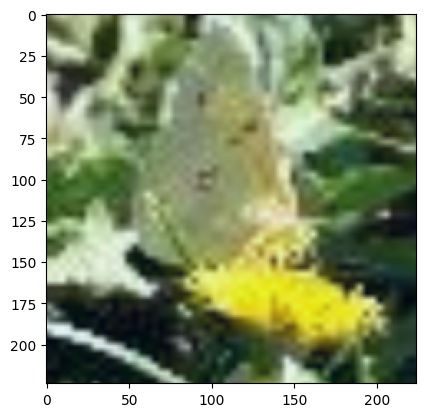

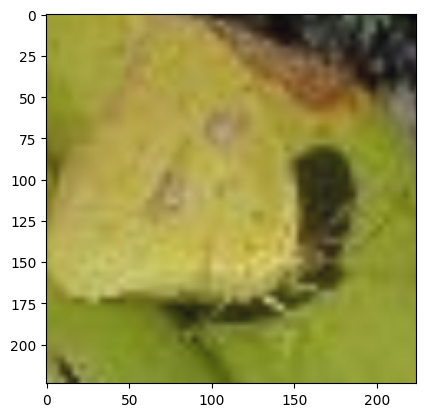

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    images = (images - images.min()) / (images.max() - images.min())
    plt.imshow(images[1].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[25].permute(1, 2, 0))
    plt.show()
    break

### Обучим нашу модель с предобученными весами

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = YourNet(pretrained=True, freeze_weights=True).to(device)
lightning_module = YourModule(model=pretrained_model, learning_rate=1e-4, optimizer='LambdaLR', lr_func=lambda epoch: 0.9**epoch)

plot_callback = PlotCallback(lightning_module)

from pytorch_lightning import Trainer
trainer_pretrained = Trainer(accelerator='cuda', max_epochs=4, callbacks=[plot_callback])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 148MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | YourNet | 7.2 M  | train
------------------------------------------
205 K     Trainable params
7.0 M     Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)
435       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 0): 5.730238437652588
Validation Accuracy (epoch 0): 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 0): 1.8762876588827486
Validation Accuracy (epoch 0): 0.5456005608200267
Train Loss (epoch 0): 2.538227462417715


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Validation Loss (epoch 1): 1.7992891152952886
Validation Accuracy (epoch 1): 0.5561609359303857
Train Loss (epoch 1): 1.7756444139504997


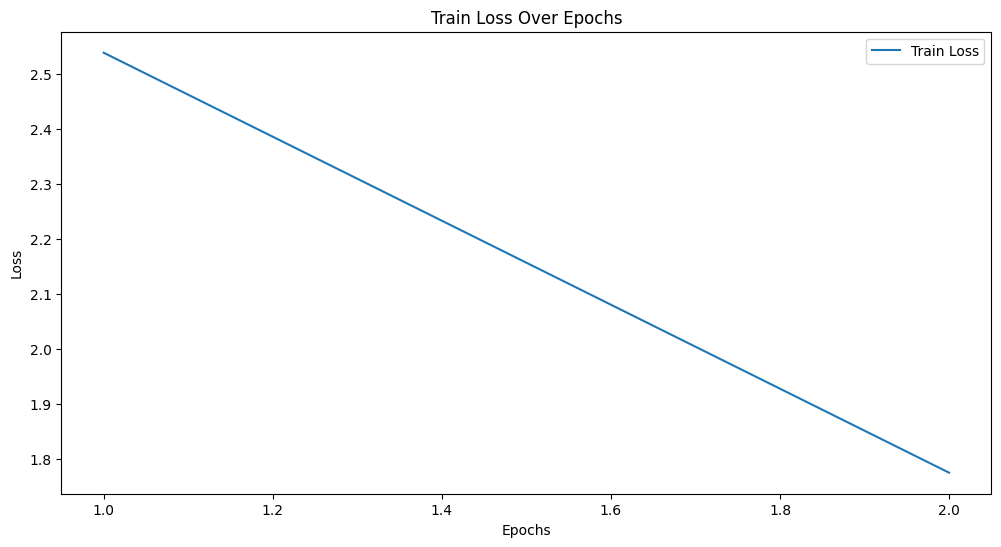

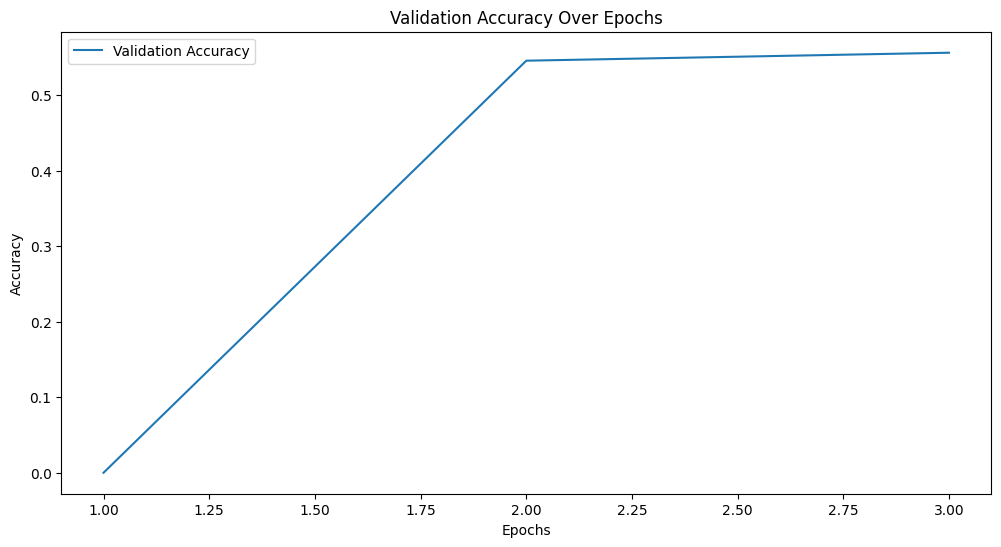

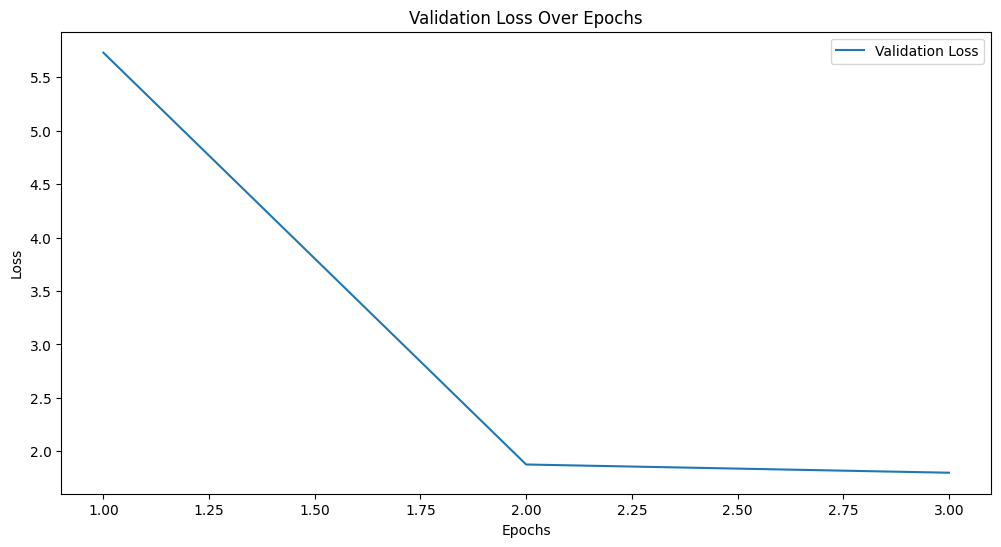

In [ ]:
trainer_pretrained.fit(lightning_module, train_dataloader, val_dataloader)

Точность равна 0.56

### Попробуем дообучить всю нейросеть без замораживания весов

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = YourNet(pretrained=True, freeze_weights=False).to(device)
lightning_module = YourModule(model=pretrained_model, learning_rate=1e-5, optimizer='LambdaLR', lr_func=lambda epoch: 0.9**epoch)

plot_callback = PlotCallback(lightning_module)

from pytorch_lightning import Trainer
trainer_pretrained = Trainer(accelerator='cuda', max_epochs=4, callbacks=[plot_callback])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 105MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | YourNet | 7.2 M  | train
------------------------------------------
7.2 M     Trainable params
0         Non-trainable params
7.2 M     Total params
28.635    Total estimated model params size (MB)
435       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 0): 5.795923471450806
Validation Accuracy (epoch 0): 0.0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 0): 1.4334421055332112
Validation Accuracy (epoch 0): 0.6487335048283741
Train Loss (epoch 0): 2.4228823312337173


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 1): 1.1667821018179512
Validation Accuracy (epoch 1): 0.7031047583385638
Train Loss (epoch 1): 1.1610166225689615


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 2): 1.1033563395594335
Validation Accuracy (epoch 2): 0.7125387522065716
Train Loss (epoch 2): 0.7663912963043477


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Loss (epoch 3): 1.0922599958766037
Validation Accuracy (epoch 3): 0.7248104207075325
Train Loss (epoch 3): 0.5010974396899657


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


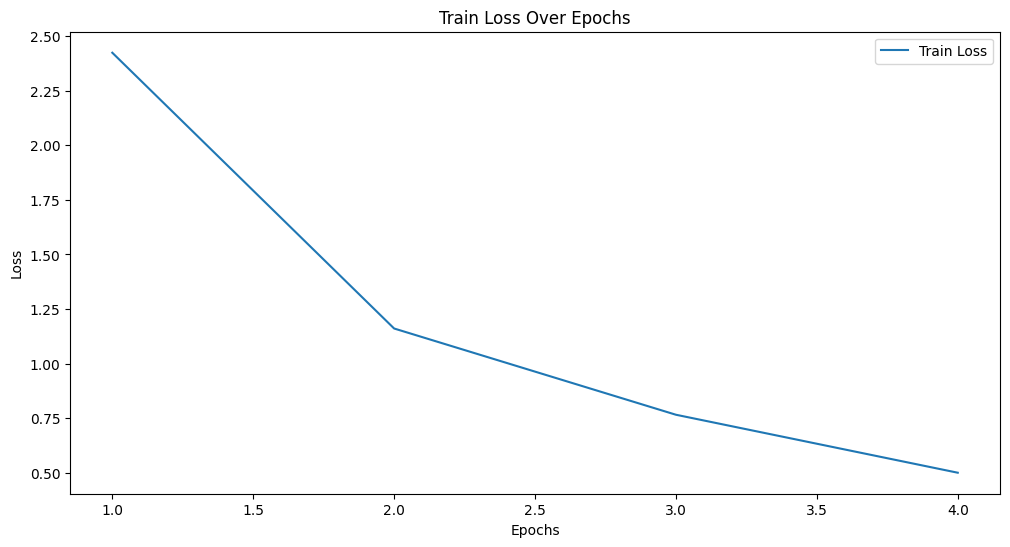

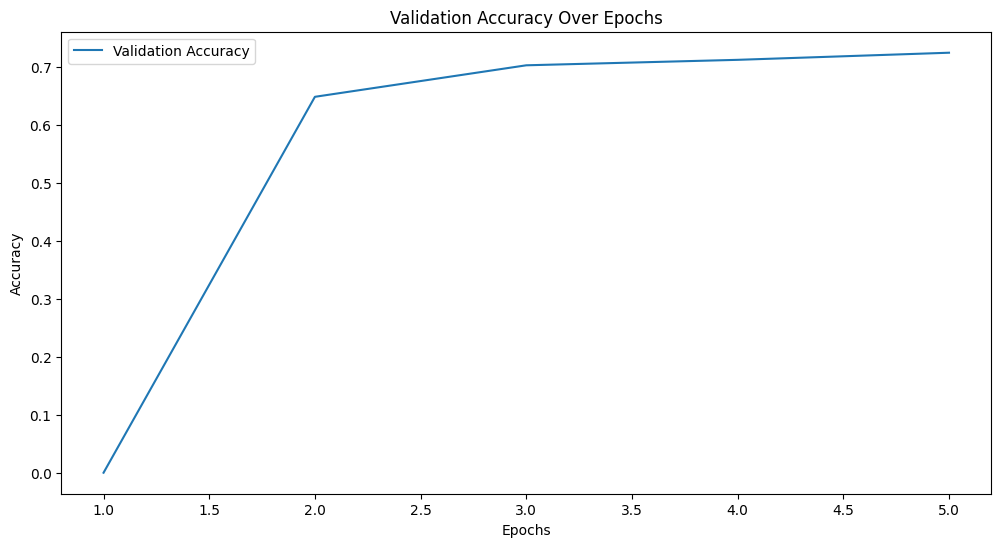

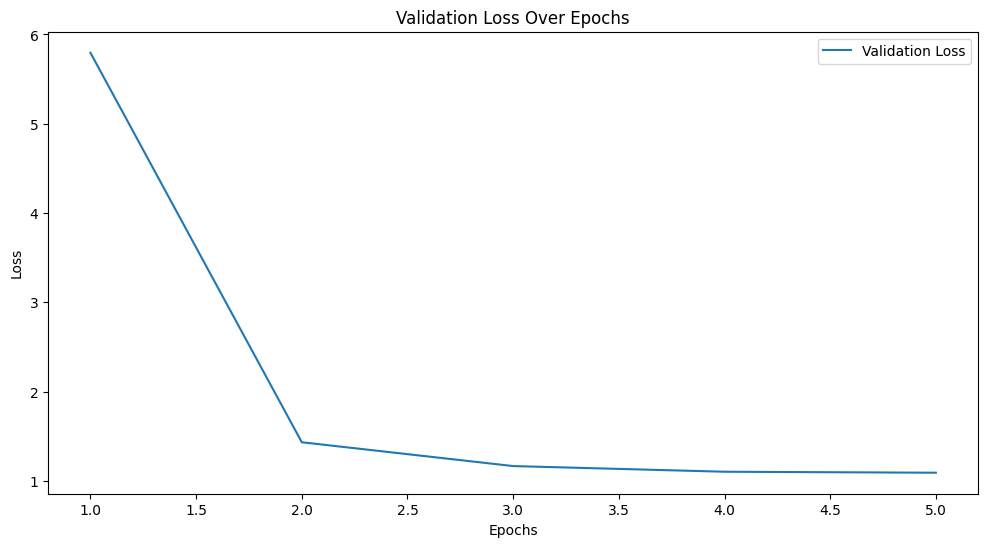

In [ ]:
# обучение 4 эпохи сниженный до 1е-4 лр
trainer_pretrained.fit(lightning_module, train_dataloader, val_dataloader)

Точность равна 0.72

### Валидация результатов задания

In [ ]:
model = pretrained_model

accuracy = evaluate_task(model, val_dataloader)

100%|██████████| 157/157 [01:03<00:00,  2.48it/s]


In [ ]:
print(f"Итоговая точность на валидации равна {(accuracy):.2f}")
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

Итоговая точность на валидации равна 0.72
Оценка за это задание составит 6.60 баллов


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/hw2model_v2_pretrained_4epochs_1e-4.pth")

## Выводы

Дообучение предварительно натренированной модели гораздо эффективнее чем обучение модели с нуля. Также гораздо эффективнее получается fine-tuning всей модели, чем обучение только головы с замораживанием весов.



| Метрика / Тип обучения | С нуля   | Только голова  | Вся модель     
|------------------------|----------|----------------|------------
| **Accuracy**            | 0.42  | 0.55   | 0.72      